In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.segmentation import mark_boundaries
import itertools
import random
import time
import pickle

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from coral_mapper_functions import score_map
from coral_mapper import coral_map

# Loading the maps

In [4]:
img_rugo_zones = np.load('../v2/data/pleiades_map_types_5m.npy')
pleiades_img = np.load('../v2/data/pleiades_ortho_5m.npy')

In [5]:
img_blue = (pleiades_img[1]-np.mean(pleiades_img[1]))/np.std(pleiades_img[1])
img_green = (pleiades_img[2]-np.mean(pleiades_img[2]))/np.std(pleiades_img[2])
img_red = (pleiades_img[3]-np.mean(pleiades_img[3]))/np.std(pleiades_img[3])
img_nir = (pleiades_img[0]-np.mean(pleiades_img[0]))/np.std(pleiades_img[0])

In [6]:
map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_zones, size_img=5)

In [7]:
classified_pixels = np.where(img_rugo_zones>0)

In [8]:
random.seed(0)
size_subset = 250000
index_combination = list(np.array(classified_pixels).T)
random_train_test = random.sample(index_combination,size_subset)
training_set_indexes_pb = random_train_test[:size_subset//5]
testing_set_indexes_pb = random_train_test[size_subset//5:]

In [9]:
%%time
map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.96672
Wall time: 3min 1s


In [10]:
%%time
map_test.predict_map_pixelbased_rf()

Wall time: 1min 6s


In [11]:
predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
score_pb = score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=5)
print(score_pb)

0.9166629248798887


In [21]:
map_test.segmentation(use_pb_pred=True, scale=1.5, sigma=1., min_size=40)

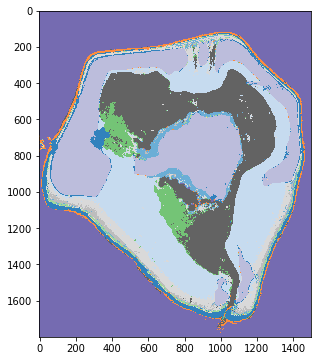

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(predicted_map_pixelbased_rf_classes, interpolation='None', cmap='tab20c_r')
plt.show()

In [22]:
map_test.smooth_pb_rf()

In [23]:
map_test.smoothed_map_pb_rf = map_test.smoothed_map_pb_rf+1

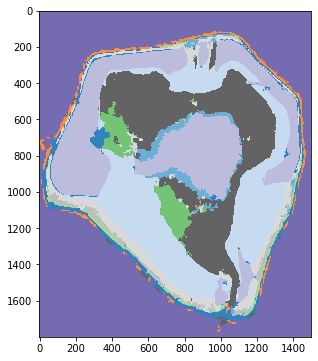

In [24]:
plt.figure(figsize=(6,6))
plt.imshow(map_test.smoothed_map_pb_rf, interpolation='None', cmap='tab20c_r')
plt.show()

In [41]:
np.max(map_test.segments)

15840

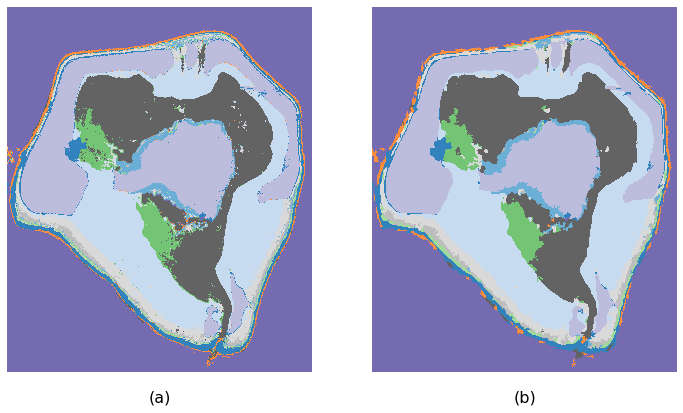

In [48]:
fig,ax = plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(predicted_map_pixelbased_rf_classes, interpolation='None', cmap='tab20c_r')
ax[0].set_title('(a)', y=-0.1, size=16)
ax[1].imshow(map_test.smoothed_map_pb_rf, interpolation='None', cmap='tab20c_r')
ax[1].set_title('(b)', y=-0.1, size=16)
ax[0].axis('off')
ax[1].axis('off')
plt.savefig('pixelbased_vs_smoothed_map_5m.png', dpi=200, bbox_inches='tight')
plt.show()